Evaluation (for TFIDF-RF)

Load the validation datasets

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
import pickle

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

In [2]:
import sys

# setting path for common utils script
sys.path.append('../')

import str_cleaning_functions
import dataset_loader

import evaluation_functions


SAVE_EVAL_RESULTS = True
SAVE_NUMPY_ARRAYS = True
LOAD_NUMPY_ARRAYS = False

In [3]:
# import importlib
# importlib.reload(evaluation_functions)

In [157]:
DATASET_SIZE = 480          # change to load different model
DATASET_IS_BALANCED = False  # change to load different model


MAX_FEATURES = 20000        # max_features params for CountVectorizer

training_args_datetime = datetime(year=2024, month=2, day=26)
training_name = 'tfidf-rf-{}_{}k_{}_{}'.format(
    MAX_FEATURES,
    DATASET_SIZE,
    'bal' if DATASET_IS_BALANCED else 'imbal',
    training_args_datetime.strftime('%Y-%m-%d')
)

training_storing_folder = Path(training_name).resolve()

In [158]:
# rerun this cell if want to evaluate a new model

X_train, X_test, y_train, y_test = dataset_loader.load_presampled_traintest_dataset(DATASET_SIZE, DATASET_IS_BALANCED)

Loaded dataset size: 480k, is_balanced: False

Training dataset class distribution
review_score
1    360011
0     71989
Name: count, dtype: int64
Testing dataset class distribution
review_score
1    39989
0     8011
Name: count, dtype: int64





In [10]:
# load validation dataset. Same for all models

X_imbal_valid, y_imbal_valid, X_bal_valid, y_bal_valid = dataset_loader.load_validation_dataset()

Loaded validation dataset

Validation dataset imbalanced class distribution
review_score
1    656654
0    134001
Name: count, dtype: int64
Validation dataset balanced class distribution
review_score
1    134294
0    134294
Name: count, dtype: int64





In [104]:
# data cleaning function

def cleaning_arr(str_arr):
    '''apply all cleaning functions to a numpy array, or a pandas series object'''
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_links(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_links2(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.clean(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.deEmojify(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_non_letters(x))
    str_arr = str_arr.apply(lambda x: x.lower())
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_stopword(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.stemming(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))

    return str_arr

def cleaning_str(_str):
    '''apply all cleaning functions to a str. Parallelize with huggingface datasets'''
    _str = str_cleaning_functions.remove_links(_str)
    _str = str_cleaning_functions.remove_links2(_str)
    _str = str_cleaning_functions.clean(_str)
    _str = str_cleaning_functions.deEmojify(_str)
    _str = str_cleaning_functions.remove_non_letters(_str)
    _str = _str.lower()
    _str = str_cleaning_functions.unify_whitespaces(_str)
    _str = str_cleaning_functions.remove_stopword(_str)
    _str = str_cleaning_functions.unify_whitespaces(_str)
    _str = str_cleaning_functions.stemming(_str)
    _str = str_cleaning_functions.unify_whitespaces(_str)

    return _str

def cleaning_dataset(data):
    return {'review_text2': cleaning_str(data['review_text'])}

In [159]:
# rerun this cell if loaded a different train/test set

from datasets import Dataset

# X_train = cleaning_arr(X_train)
# X_test = cleaning_arr(X_test)

# temp_dataset = Dataset.from_dict({
#     'review_text': X_train.values,
# })
# temp_dataset = temp_dataset.map(cleaning_dataset, num_proc=4)
# X_train = temp_dataset['review_text2']

temp_dataset = Dataset.from_dict({
    'review_text': X_test.values,
})
temp_dataset = temp_dataset.map(cleaning_dataset, num_proc=4)
X_test = temp_dataset['review_text2']

# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

Map (num_proc=4): 100%|██████████| 432000/432000 [00:39<00:00, 10956.81 examples/s]
/root/miniforge3/envs/fyp-test-wsl/lib/python3.9/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/root/miniforge3/envs/fyp-test-wsl/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
Map (num_proc=4): 100%|██████████| 48000/48000 [00:04<00:00, 10191.53 examples/s]


In [16]:
from datasets import Dataset

# X_imbal_valid = cleaning_arr(X_imbal_valid)
# X_bal_valid = cleaning_arr(X_bal_valid)

# use datasets to parallelize the cleaning process

temp_dataset = Dataset.from_dict({
    'review_text': X_imbal_valid.values
})
temp_dataset = temp_dataset.map(cleaning_dataset, num_proc=4)
X_imbal_valid = temp_dataset['review_text2']

temp_dataset = Dataset.from_dict({
    'review_text': X_bal_valid.values
})
temp_dataset = temp_dataset.map(cleaning_dataset, num_proc=4)
X_bal_valid = temp_dataset['review_text2']

# X_bal_valid = X_bal_valid.to_numpy()
# y_bal_valid = y_bal_valid.to_numpy()

# X_imbal_valid = X_imbal_valid.to_numpy()
# y_imbal_valid = y_imbal_valid.to_numpy()

Map (num_proc=4): 100%|██████████| 790655/790655 [01:07<00:00, 11752.35 examples/s]
/root/miniforge3/envs/fyp-test-wsl/lib/python3.9/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/root/miniforge3/envs/fyp-test-wsl/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
Map (num_proc=4): 100%|██████████| 268588/268588 [00:23<00:00, 11369.01 examples/s]


In [77]:
print('Validation (imbalanced) set')
print(len(X_imbal_valid))
print(len(y_imbal_valid))
print()
print('Validation (balanced) set')
print(len(X_bal_valid))
print(len(y_bal_valid))

print()
print()

print('Validation (imbalanced) set')
print(pd.Series(y_imbal_valid).value_counts())
print()
print('Validation (balanced) set')
print(pd.Series(y_bal_valid).value_counts())

print()
print()

print('validation (imbalanced) set datatype')
print(type(X_imbal_valid))
print(type(y_imbal_valid))
print()
print('validation (balanced) set datatype')
print(type(X_bal_valid))
print(type(y_bal_valid))

Validation (imbalanced) set
790655
790655

Validation (balanced) set
268588
268588


Validation (imbalanced) set
review_score
1    656654
0    134001
Name: count, dtype: int64

Validation (balanced) set
review_score
1    134294
0    134294
Name: count, dtype: int64


validation (imbalanced) set datatype
<class 'list'>
<class 'pandas.core.series.Series'>

validation (balanced) set datatype
<class 'list'>
<class 'pandas.core.series.Series'>


---

Load the models

Rerun all cells below if loading a new model

In [160]:
from datetime import datetime
import pickle

rf_model_path = Path.joinpath(training_storing_folder, "{}_model.sav".format(
    training_name
))
model = pickle.load(open(rf_model_path, 'rb'))

count_vectorizer_path = Path.joinpath(training_storing_folder, "{}_count_vectorizer.pkl".format(
    training_name
))
vectorizer = pickle.load(open(count_vectorizer_path, 'rb'))

tfidf_transformer_path = Path.joinpath(training_storing_folder, "{}_tfidf.pkl".format(
    training_name
))
tfidf = pickle.load(open(tfidf_transformer_path, 'rb'))

print('Loaded model from {}'.format(rf_model_path))
print('Loaded count vectorizer from {}'.format(count_vectorizer_path))
print('Loaded tfidf transformer from {}'.format(tfidf_transformer_path))

Loaded model from /root/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal_2024-02-26/tfidf-rf-20000_480k_imbal_2024-02-26_model.sav
Loaded count vectorizer from /root/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal_2024-02-26/tfidf-rf-20000_480k_imbal_2024-02-26_count_vectorizer.pkl
Loaded tfidf transformer from /root/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal_2024-02-26/tfidf-rf-20000_480k_imbal_2024-02-26_tfidf.pkl


---

Evaluation

In [161]:
from sklearn.pipeline import Pipeline

pipeline_test = Pipeline([
    ('vect', vectorizer),
    ('tfidf', tfidf),
    ('model', model),
])

In [162]:
# create folders for storing evaluation metrics

eval_metrics_folder = Path.joinpath(training_storing_folder, 'eval_metrics')

if not eval_metrics_folder.exists():
    eval_metrics_folder.mkdir()

eval_test_prefix = 'test'
eval_valid_bal_prefix = 'valid_bal'
eval_valid_imbal_prefix = 'valid_imbal'

eval_test_folder = Path.joinpath(eval_metrics_folder, eval_test_prefix)
eval_valid_bal_folder = Path.joinpath(eval_metrics_folder, eval_valid_bal_prefix)
eval_valid_imbal_folder = Path.joinpath(eval_metrics_folder, eval_valid_imbal_prefix)

if not eval_test_folder.exists():
    eval_test_folder.mkdir()

if not eval_valid_bal_folder.exists():
    eval_valid_bal_folder.mkdir()

if not eval_valid_imbal_folder.exists():
    eval_valid_imbal_folder.mkdir()

print('Folders for storing evaluation metrics')
print(eval_test_folder)
print(eval_valid_bal_folder)
print(eval_valid_imbal_folder)

Folders for storing evaluation metrics
/root/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal_2024-02-26/eval_metrics/test
/root/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal_2024-02-26/eval_metrics/valid_bal
/root/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal_2024-02-26/eval_metrics/valid_imbal


on test set

In [163]:
if LOAD_NUMPY_ARRAYS:
    y_test_pred_prob_raw = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'))
    y_test_pred = np.load(Path.joinpath(eval_test_folder, 'y_test_pred.npy'))
    y_test_pred_prob = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob.npy'))
    y_test = np.load(Path.joinpath(eval_test_folder, 'y_test.npy'))
else:
    y_test_pred_prob_raw = pipeline_test.predict_proba(X_test)

    y_test_pred = np.argmax(y_test_pred_prob_raw, axis=1)

    y_test_pred_prob = y_test_pred_prob_raw if len(np.unique(y_test_pred)) > 2 \
                    else np.array([y_test_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_test_pred))])

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    1.5s


In [164]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'), y_test_pred_prob_raw)
    np.save(Path.joinpath(eval_test_folder, 'y_test_pred.npy'), y_test_pred)
    np.save(Path.joinpath(eval_test_folder, 'y_test_pred_prob.npy'), y_test_pred_prob)
    np.save(Path.joinpath(eval_test_folder, 'y_test.npy'), y_test)

In [165]:
test_classification_report_dict = evaluation_functions.print_classification_report(y_test, y_test_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.31      0.45      8011
           1       0.88      0.99      0.93     39989

    accuracy                           0.87     48000
   macro avg       0.85      0.65      0.69     48000
weighted avg       0.87      0.87      0.85     48000



TN - True Negative 2498
FN - False Negative 553
TP - True Positive 39436
FP - False Positive 5513
Accuracy Rate: 0.873625
Misclassification Rate: 0.126375
F1-Score: 0.6901097170054876
ROC-AUC 0.6489962214331197


In [166]:
test_classification_report_dict

{'0': {'precision': 0.8187479514913143,
  'recall': 0.3118212457870428,
  'f1-score': 0.4516362321460856,
  'support': 8011.0},
 '1': {'precision': 0.8773498854257047,
  'recall': 0.9861711970791968,
  'f1-score': 0.9285832018648896,
  'support': 39989.0},
 'accuracy': 0.873625,
 'macro avg': {'precision': 0.8480489184585095,
  'recall': 0.6489962214331197,
  'f1-score': 0.6901097170054876,
  'support': 48000.0},
 'weighted avg': {'precision': 0.8675694668267797,
  'recall': 0.873625,
  'f1-score': 0.8489827398978617,
  'support': 48000.0}}

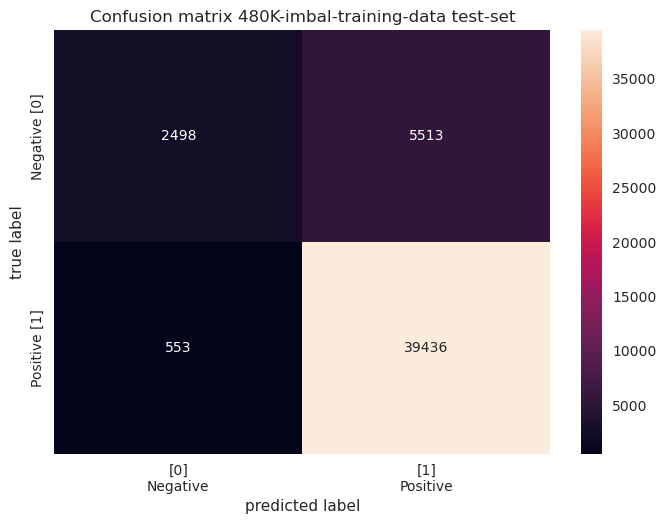

In [167]:
import matplotlib as plt
# plt.style.use('seaborn-v0_8-dark')
plt.style.use('seaborn-v0_8')

evaluation_functions.create_confusion_matrix_graph(
    y_test,
    y_test_pred,
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'confusion_matrix_test.png'),
    show=True
)

0.8735227615131297


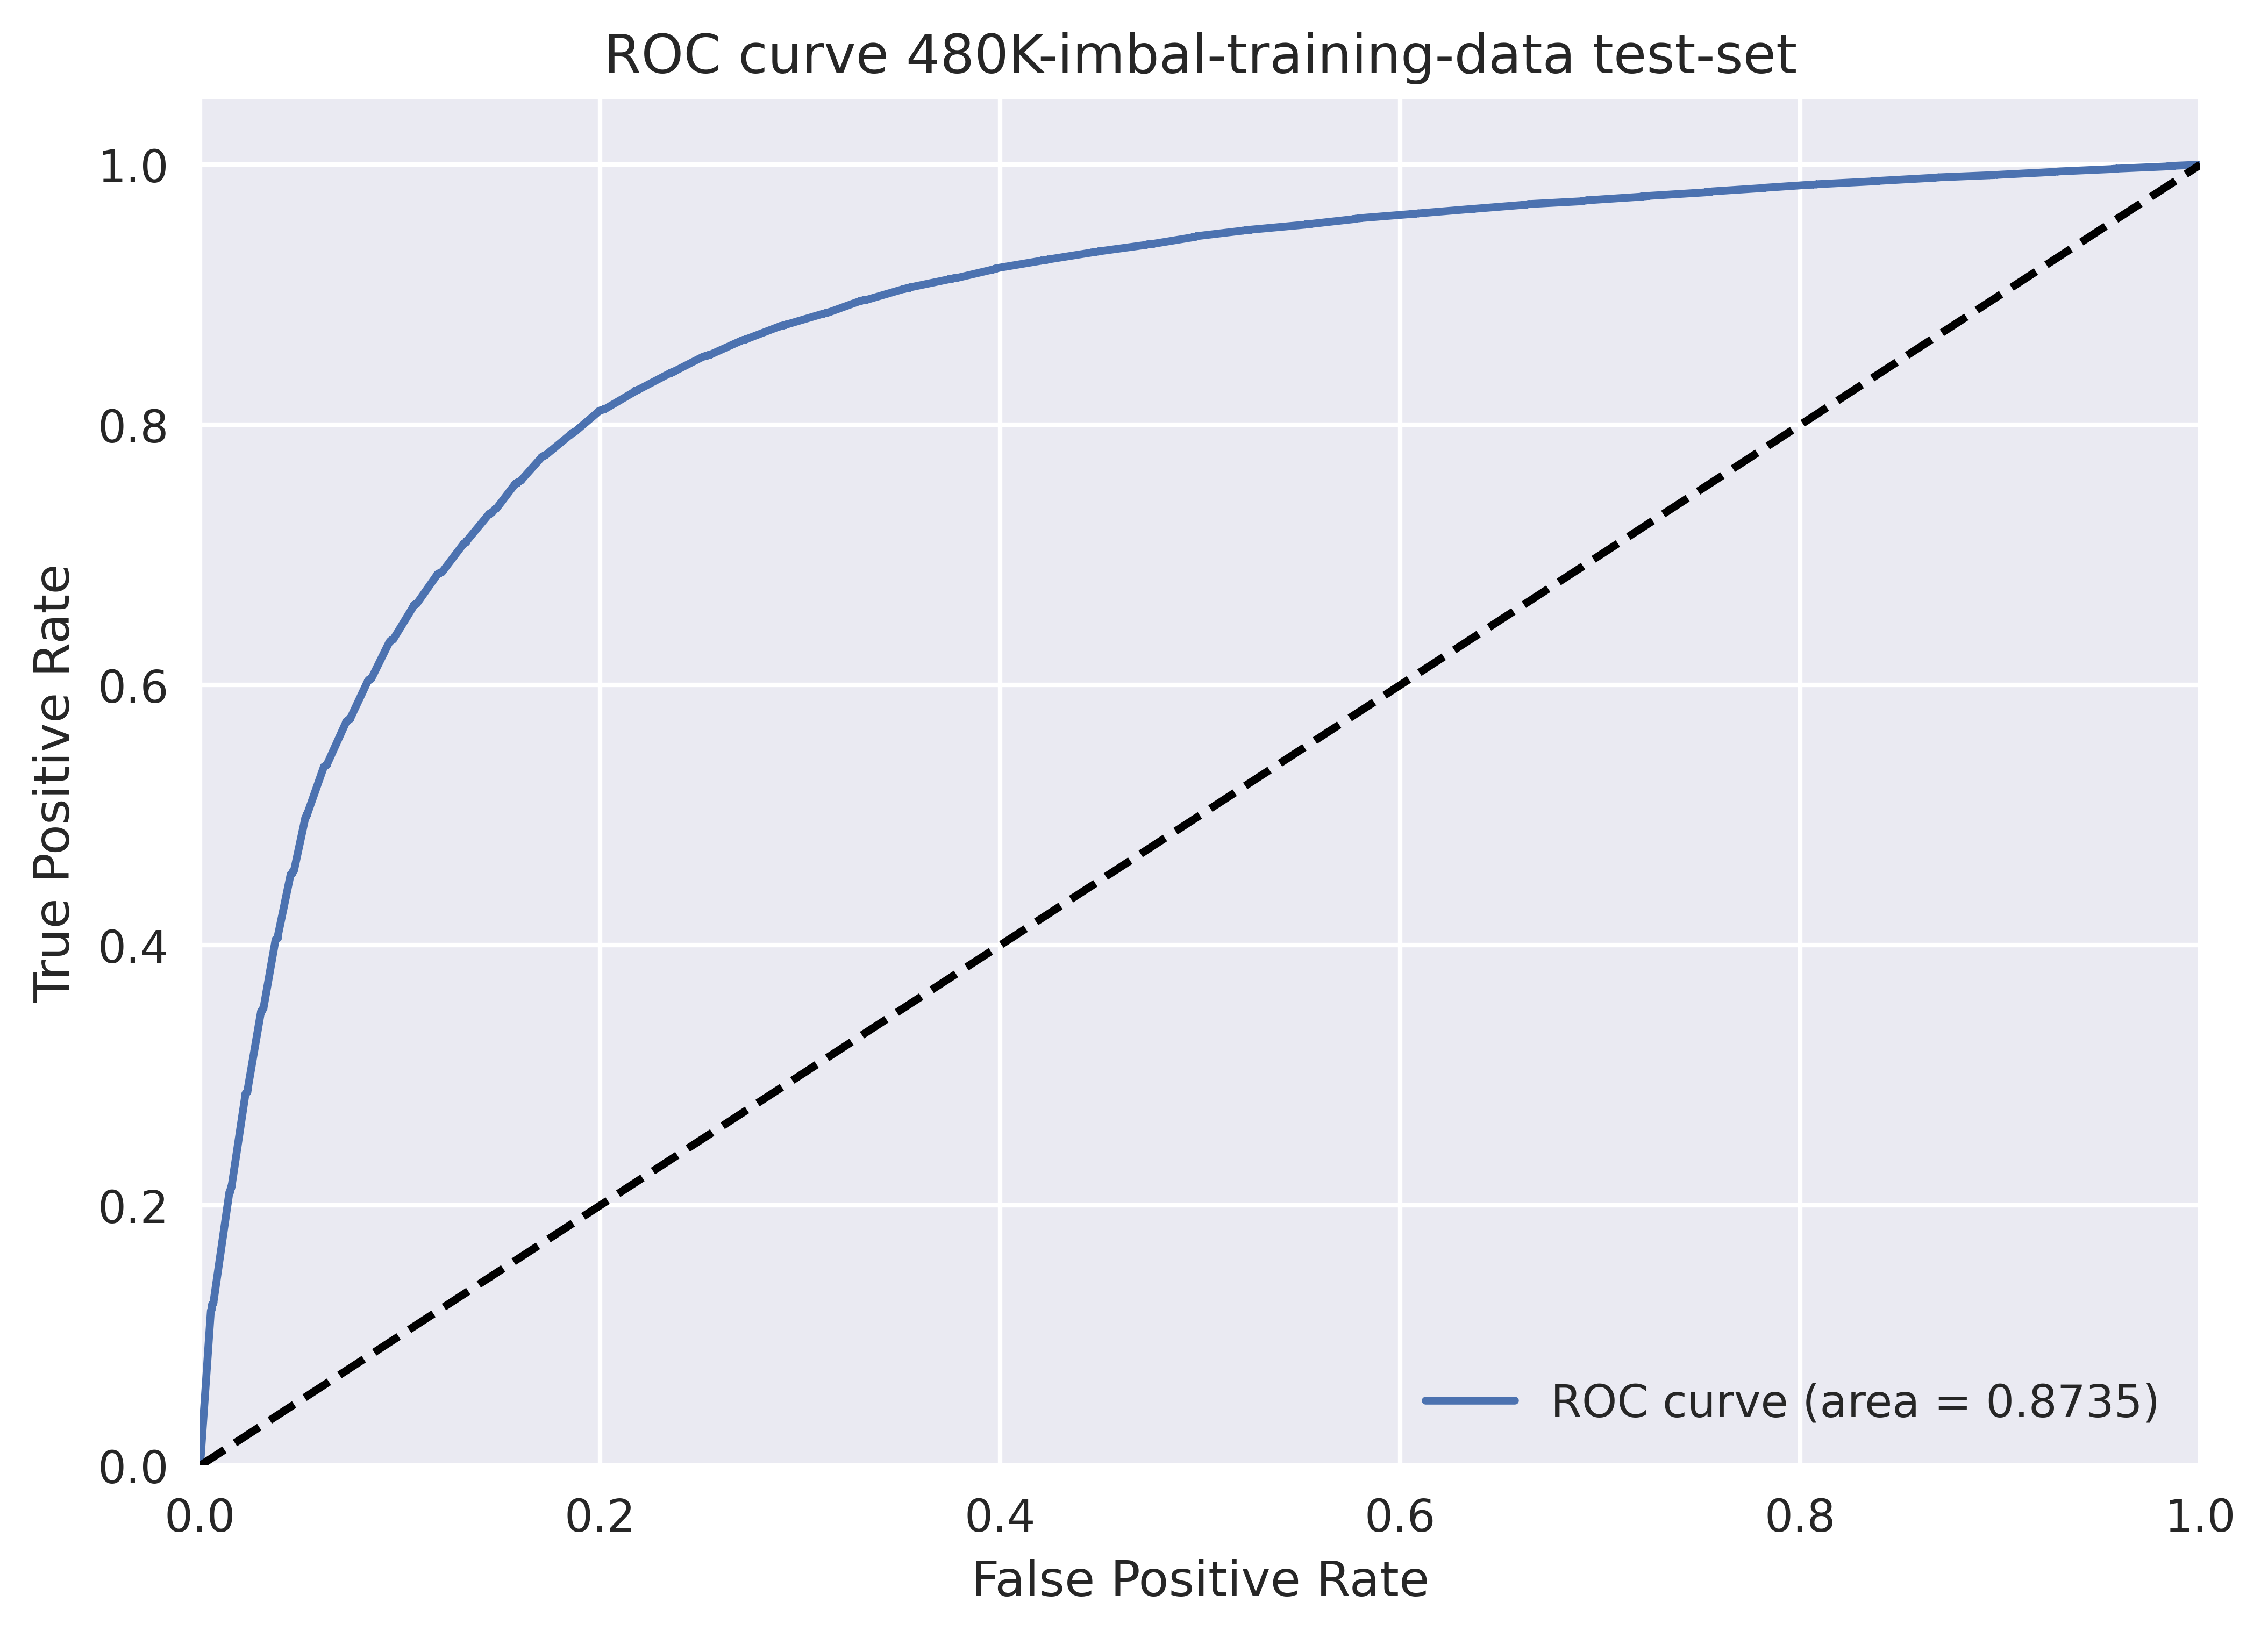

In [168]:
evaluation_functions.plot_roc_curve_binary(
    y_test,
    y_test_pred_prob,
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'roc_curve_test.png'),
    show=True
)

In [169]:
from sklearn.metrics import roc_auc_score

# import importlib
# importlib.reload(evaluation_functions)

# add ROC area to report_dict
test_classification_report_dict['roc_auc'] = roc_auc_score(y_test, y_test_pred_prob)

test_report_df = evaluation_functions.create_classification_report_df(
    test_classification_report_dict, 
    training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    test_report_df.to_csv(Path.joinpath(eval_test_folder, "{}_{}_test_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed balanced validation set

In [170]:
if LOAD_NUMPY_ARRAYS:
    y_bal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob_raw.npy'))
    y_bal_valid_pred = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred.npy'))
    y_bal_valid_pred_prob = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob.npy'))
    y_bal_valid = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid.npy'))
else:
    y_bal_valid_pred_prob_raw = pipeline_test.predict_proba(X_bal_valid)

    y_bal_valid_pred = np.argmax(y_bal_valid_pred_prob_raw, axis=1)

    y_bal_valid_pred_prob = y_bal_valid_pred_prob_raw if len(np.unique(y_bal_valid_pred)) > 2 \
                    else np.array([y_bal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_bal_valid_pred))])

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    7.1s


In [171]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob_raw.npy'), y_bal_valid_pred_prob_raw)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred.npy'), y_bal_valid_pred)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob.npy'), y_bal_valid_pred_prob)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid.npy'), y_bal_valid)

In [172]:
bal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_bal_valid, y_bal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.30      0.46    134294
           1       0.58      0.99      0.73    134294

    accuracy                           0.64    268588
   macro avg       0.77      0.64      0.60    268588
weighted avg       0.77      0.64      0.60    268588



TN - True Negative 40412
FN - False Negative 2012
TP - True Positive 132282
FP - False Positive 93882
Accuracy Rate: 0.6429699018571194
Misclassification Rate: 0.35703009814288056
F1-Score: 0.5956638388844839
ROC-AUC 0.6429699018571194


In [173]:
bal_valid_classification_result_dict

{'0': {'precision': 0.9525740147086554,
  'recall': 0.30092185801301624,
  'f1-score': 0.4573614459194876,
  'support': 134294.0},
 '1': {'precision': 0.5848941476096992,
  'recall': 0.9850179457012227,
  'f1-score': 0.7339662318494803,
  'support': 134294.0},
 'accuracy': 0.6429699018571194,
 'macro avg': {'precision': 0.7687340811591773,
  'recall': 0.6429699018571194,
  'f1-score': 0.5956638388844839,
  'support': 268588.0},
 'weighted avg': {'precision': 0.7687340811591773,
  'recall': 0.6429699018571194,
  'f1-score': 0.595663838884484,
  'support': 268588.0}}

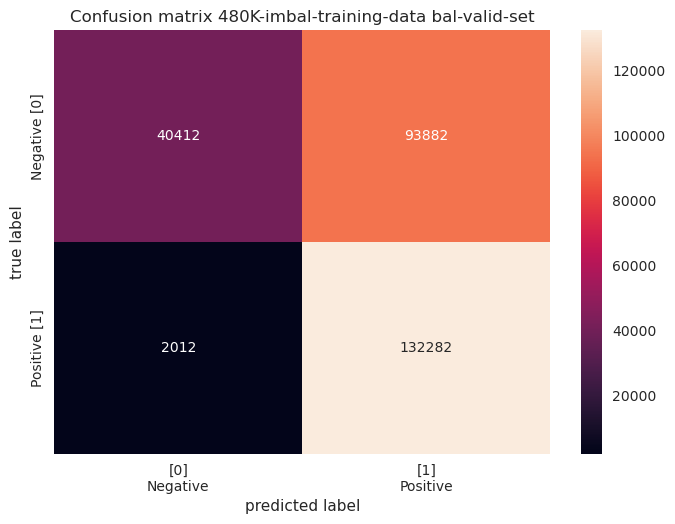

In [174]:
evaluation_functions.create_confusion_matrix_graph(
    y_bal_valid, y_bal_valid_pred, 
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'confusion_matrix_valid_bal.png'),
    show=True
)

0.871493178469462


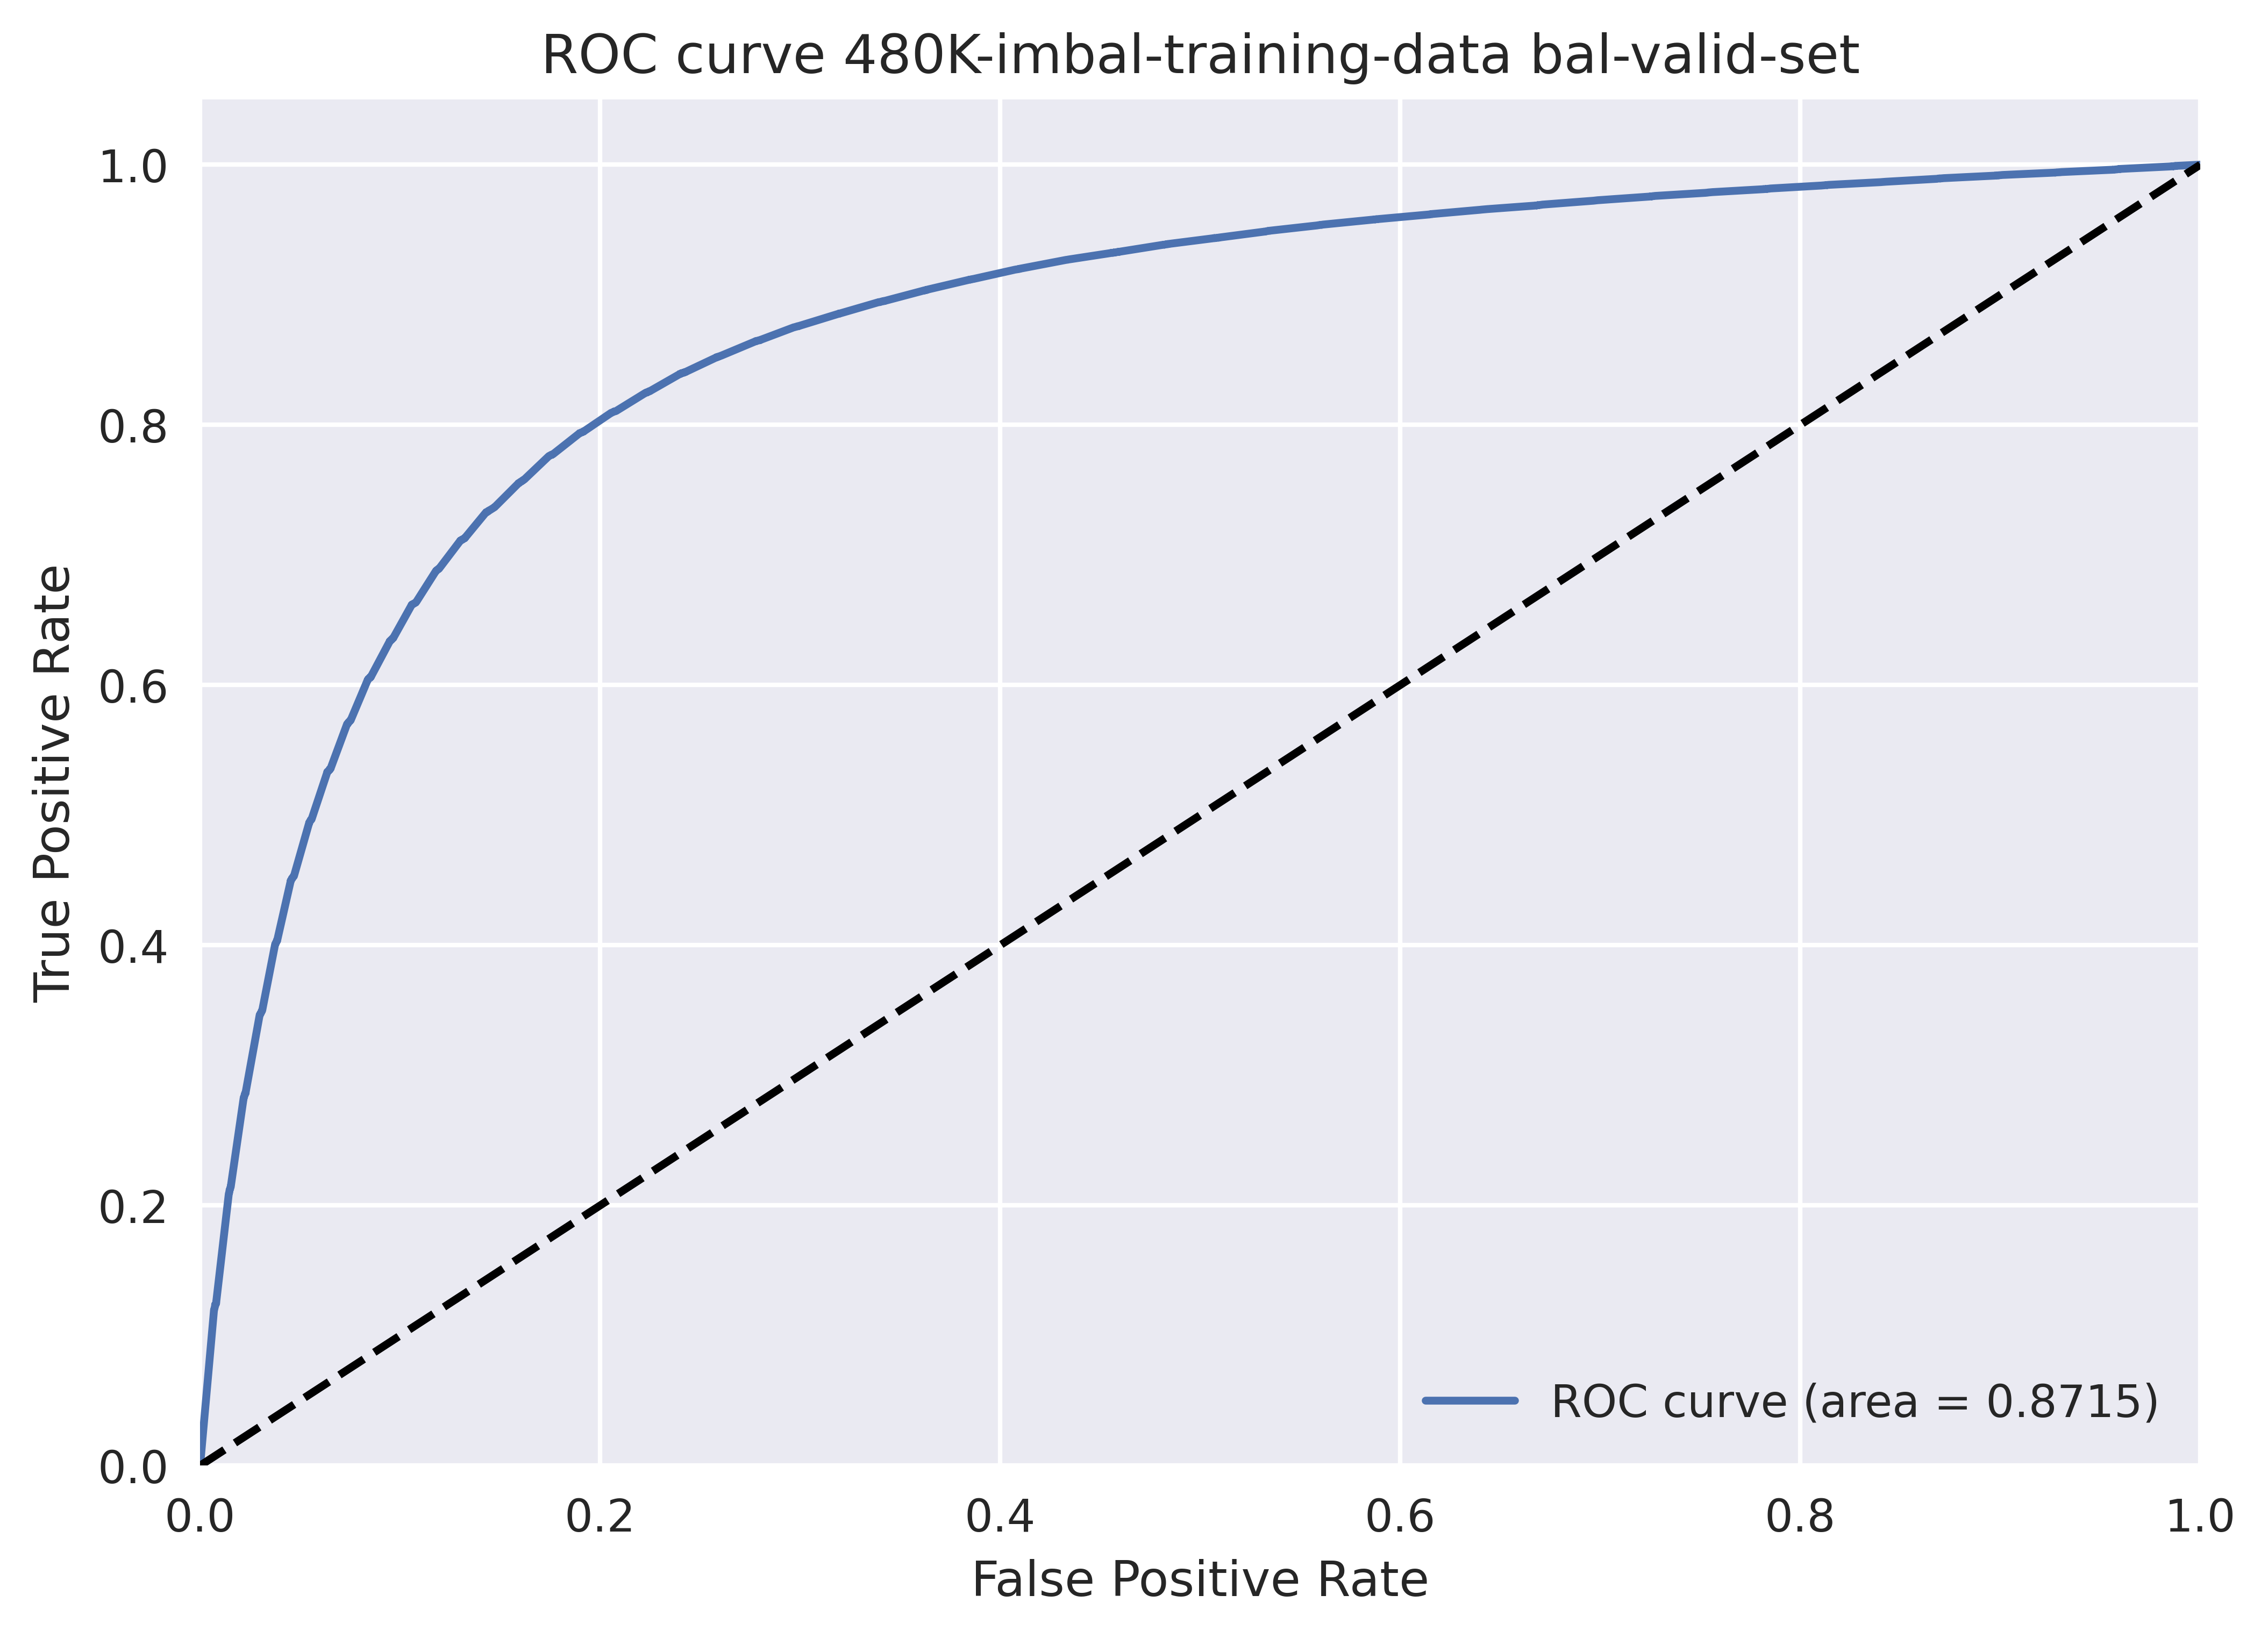

In [175]:
evaluation_functions.plot_roc_curve_binary(
    y_bal_valid, y_bal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set', 
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'roc_curve_valid_bal.png'),
    show=True
)

In [176]:
# add ROC area to report_dict
bal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_bal_valid, y_bal_valid_pred_prob)

bal_valid_report_df = evaluation_functions.create_classification_report_df(bal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    bal_valid_report_df.to_csv(Path.joinpath(eval_valid_bal_folder, "{}_{}_valid_bal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed validation set (imbalanced)

In [177]:
if LOAD_NUMPY_ARRAYS:
    y_imbal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'))
    y_imbal_valid_pred = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'))
    y_imbal_valid_pred_prob = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'))
    y_imbal_valid = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'))
else:
    y_imbal_valid_pred_prob_raw = pipeline_test.predict_proba(X_imbal_valid)

    y_imbal_valid_pred = np.argmax(y_imbal_valid_pred_prob_raw, axis=1)

    y_imbal_valid_pred_prob = y_imbal_valid_pred_prob_raw if len(np.unique(y_imbal_valid_pred)) > 2 \
                    else np.array([y_imbal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_imbal_valid_pred))])

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   21.7s


In [178]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'), y_imbal_valid_pred_prob_raw)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'), y_imbal_valid_pred)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'), y_imbal_valid_pred_prob)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'), y_imbal_valid)

In [179]:
imbal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_imbal_valid, y_imbal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.30      0.44    134001
           1       0.87      0.99      0.93    656654

    accuracy                           0.87    790655
   macro avg       0.84      0.64      0.68    790655
weighted avg       0.86      0.87      0.84    790655



TN - True Negative 40409
FN - False Negative 9729
TP - True Positive 646925
FP - False Positive 93592
Accuracy Rate: 0.8693222707754963
Misclassification Rate: 0.13067772922450374
F1-Score: 0.6824732783155698
ROC-AUC 0.6433707146159524


In [180]:
imbal_valid_classification_result_dict

{'0': {'precision': 0.805955562647094,
  'recall': 0.30155745106379805,
  'f1-score': 0.438896703034121,
  'support': 134001.0},
 '1': {'precision': 0.8736126246932886,
  'recall': 0.9851839781681068,
  'f1-score': 0.9260498535970185,
  'support': 656654.0},
 'accuracy': 0.8693222707754963,
 'macro avg': {'precision': 0.8397840936701912,
  'recall': 0.6433707146159524,
  'f1-score': 0.6824732783155698,
  'support': 790655.0},
 'weighted avg': {'precision': 0.8621460381653439,
  'recall': 0.8693222707754963,
  'f1-score': 0.8434866505203557,
  'support': 790655.0}}

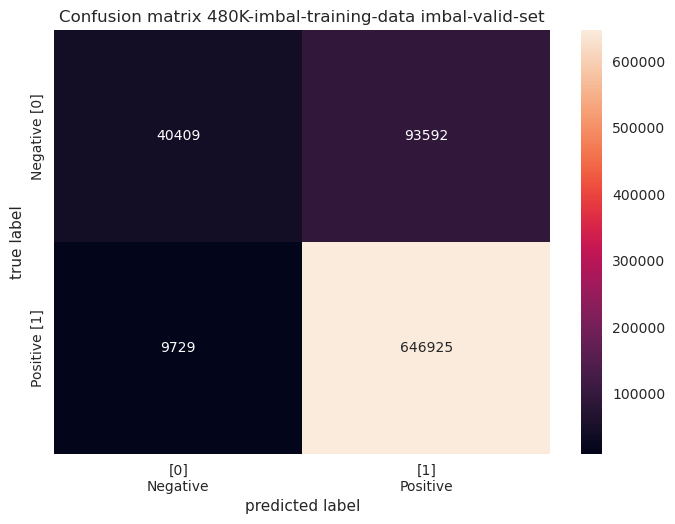

In [181]:
evaluation_functions.create_confusion_matrix_graph(
    y_imbal_valid, y_imbal_valid_pred, 
    title=f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'confusion_matrix_valid_imbal.png'),
    show=True
)

0.8723053848854428


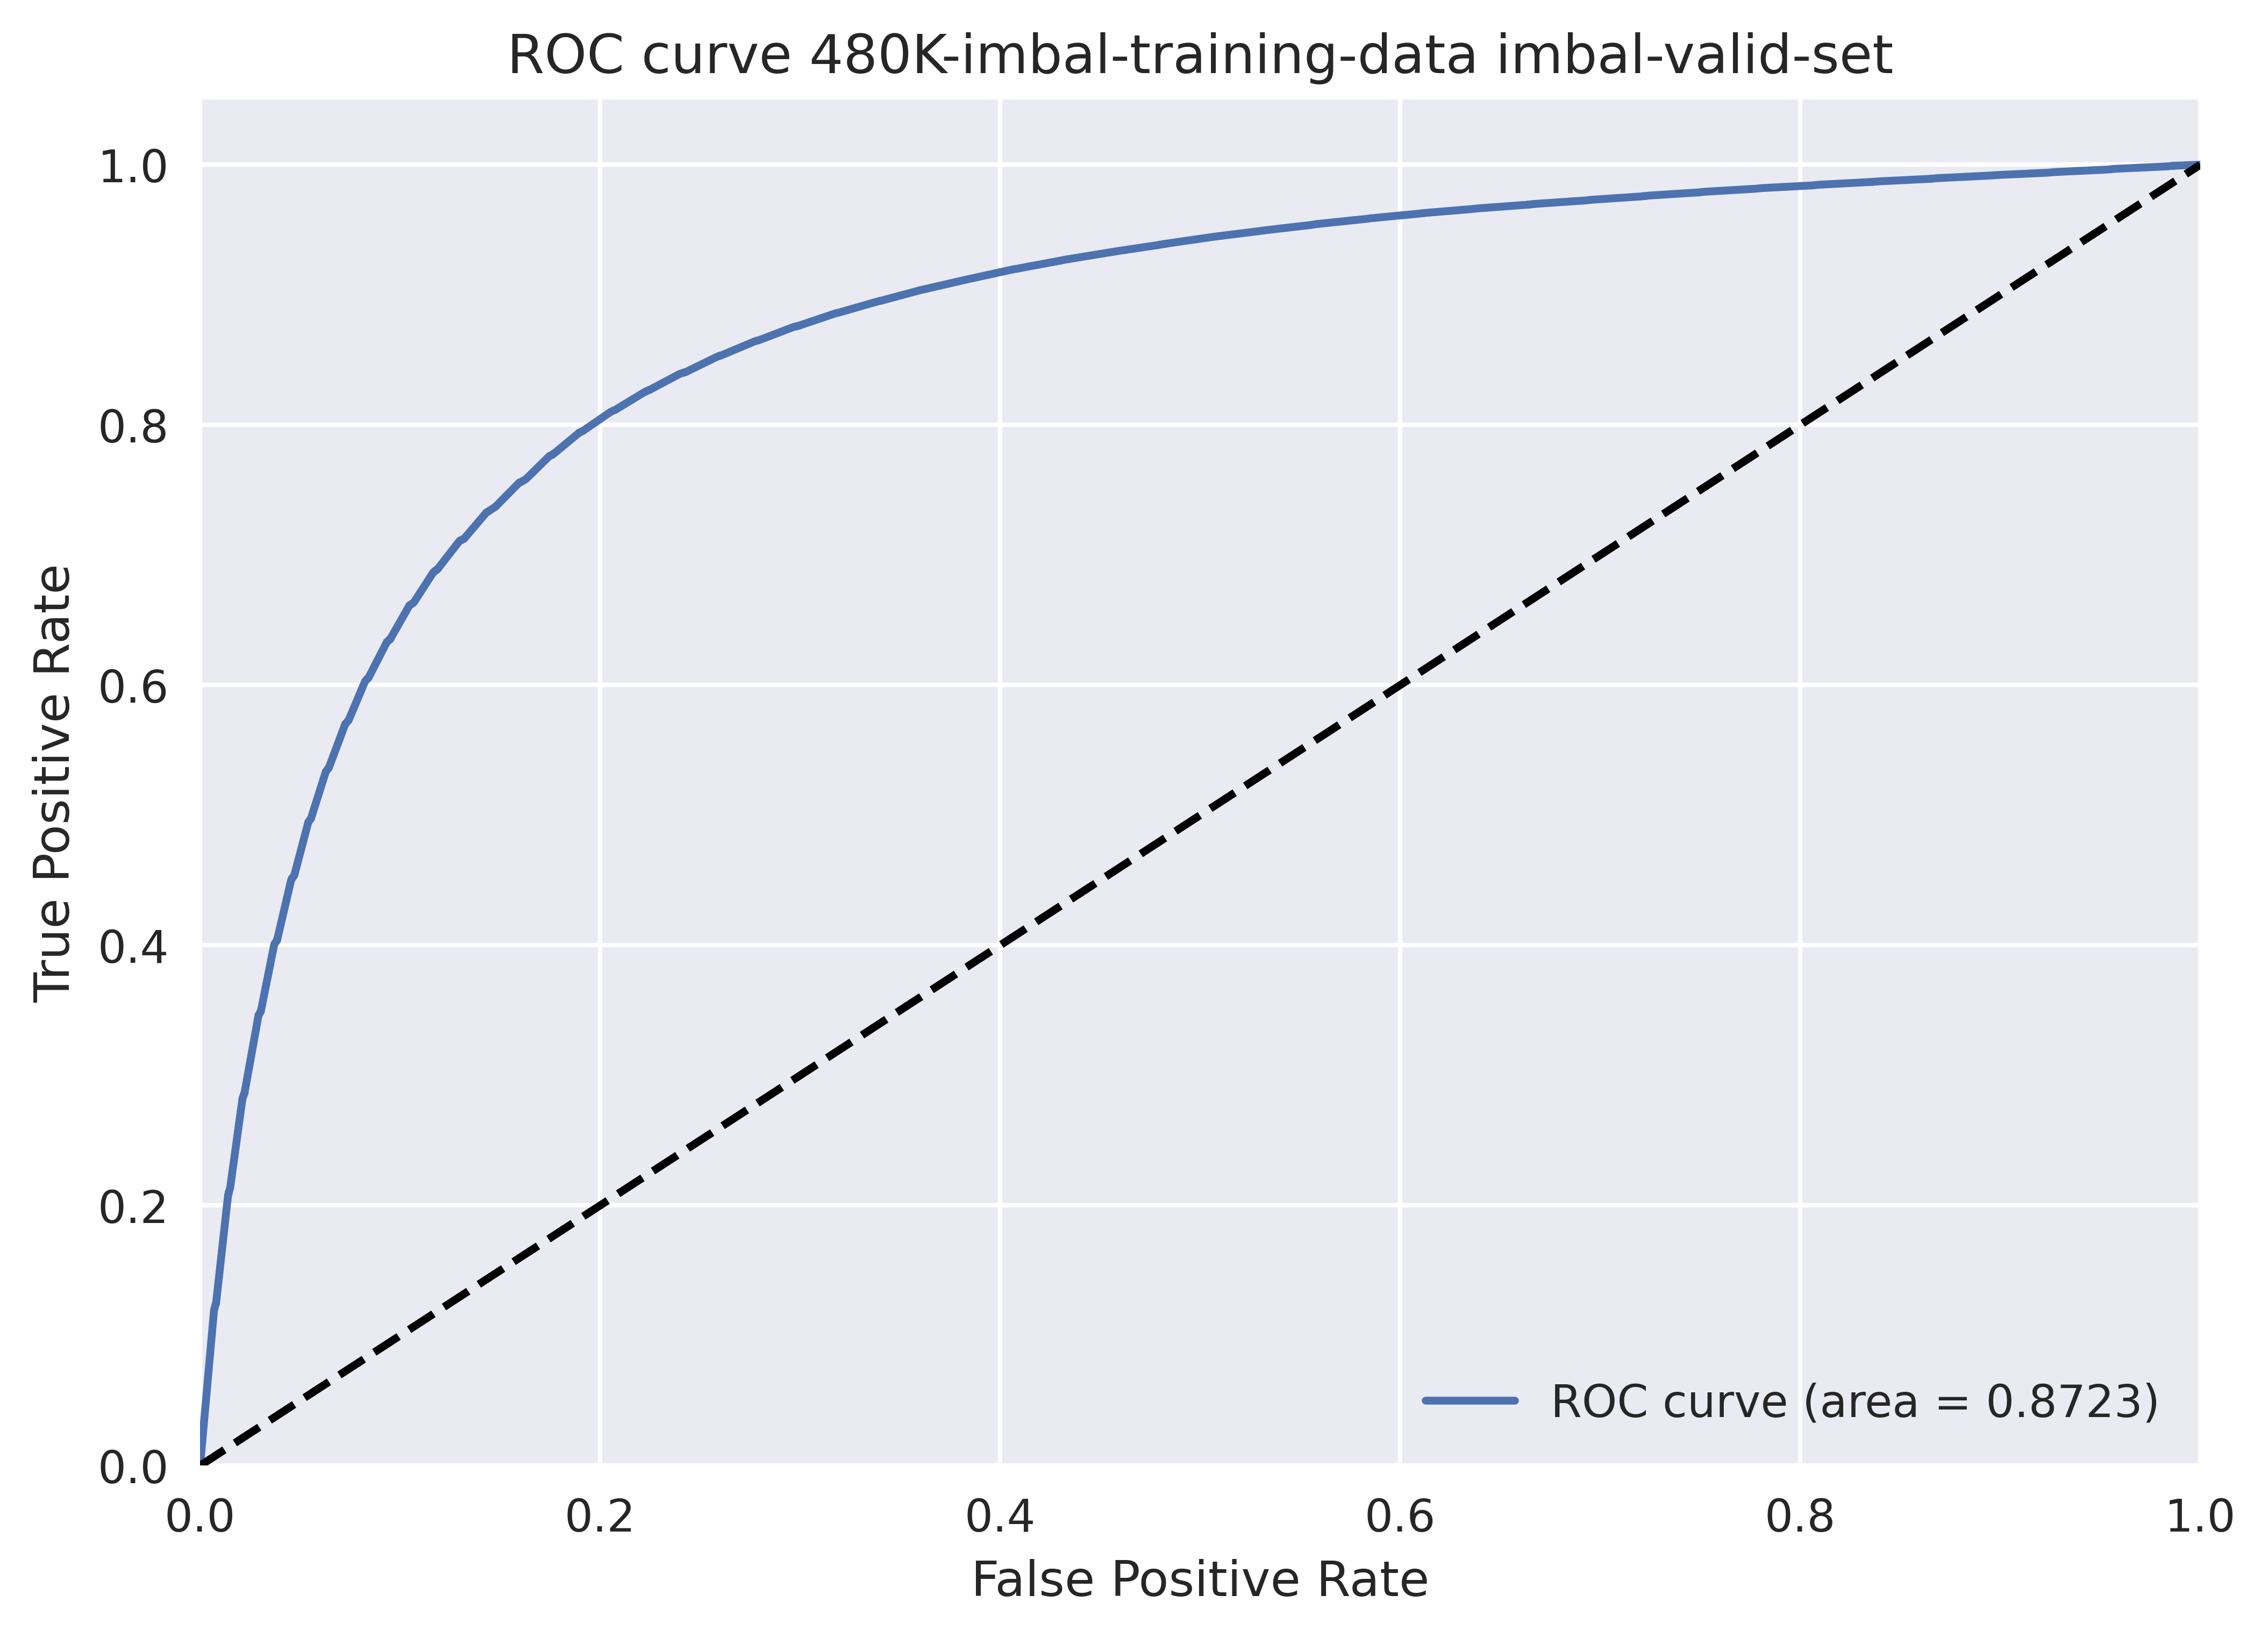

In [182]:
evaluation_functions.plot_roc_curve_binary(
    y_imbal_valid, y_imbal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'roc_curve_valid_imbal.png'),
    show=True
)

In [183]:
# add ROC area to report_dict
imbal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_imbal_valid, y_imbal_valid_pred_prob)

imbal_valid_report_df = evaluation_functions.create_classification_report_df(imbal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    imbal_valid_report_df.to_csv(Path.joinpath(eval_valid_imbal_folder, "{}_{}_valid_imbal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

Evluation end